In [119]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#设置中文显示
plt.rcParams['font.sans-serif']=['SimHei']
# 解决负号无法显示的问题
plt.rcParams['axes.unicode_minus'] =False

In [120]:
#导入数据,数据无表头，需设置header=None
df5 = pd.read_csv('datasets\capacity_5.csv',header=None)
df6 = pd.read_csv('datasets\capacity_6.csv',header=None)
df7 = pd.read_csv('datasets\capacity_7.csv',header=None)
df18 = pd.read_csv('datasets\capacity_18.csv',header=None)

pred5 = pd.read_csv('.\datasets\B0005Pred.csv',header=None)
pred6 = pd.read_csv('.\datasets\B0006Pred.csv',header=None)
pred7 = pd.read_csv('.\datasets\B0007Pred.csv',header=None)
pred18 = pd.read_csv('.\datasets\B0018Pred.csv',header=None)

#转换为numpy数组
capacity_5 = df5.values
capacity_6 = df6.values
capacity_7 = df7.values
capacity_18 = df18.values
real_5=capacity_5
real_6=capacity_6
real_7=capacity_7
real_18=capacity_18

In [121]:
#统一归一化
scaler = MinMaxScaler(feature_range=(0, 1))
capacity=np.vstack((capacity_5,capacity_6,capacity_7,capacity_18))
scaler.fit_transform(capacity)
capacity_5 = scaler.transform(capacity_5)
capacity_6 = scaler.transform(capacity_6)
capacity_7 = scaler.transform(capacity_7)
capacity_18 = scaler.transform(capacity_18)

In [122]:
#转换为时间序列数据
window_size=3
def time_series(dataset, window_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-window_size):
        a = dataset[i:(i+window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return np.array(data_X), np.array(data_Y).reshape(-1,1)


sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size)
sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size)
sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size)
sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size)
_,y_5=time_series(real_5,window_size)
_,y_6=time_series(real_6,window_size)
_,y_7=time_series(real_7,window_size)
_,y_18=time_series(real_18,window_size)


In [123]:
#连接数据
sequ_x=np.vstack((sequ_x_5,sequ_x_6,sequ_x_7,sequ_x_18))
sequ_y=np.vstack((sequ_y_5,sequ_y_6,sequ_y_7,sequ_y_18))
sequ_x_5.shape,sequ_y.shape


((165, 3), (624, 1))

In [124]:
#构建LSTM模型
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# #搭建LSTM模型
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(sequ_x.shape[1],1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))
# model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(sequ_x, sequ_y, epochs=100, batch_size=32)

# #预测
# y_pred_5 = model.predict(sequ_x_5)
# #反归一化
# y_pred_5 = scaler.inverse_transform(y_pred_5)


In [125]:
# plt.plot(y_5, color = 'red', label = 'Real capacity')
# plt.plot(y_pred_5, color = 'blue', label = 'Predicted capacity')
# plt.title('capacity prediction')
# plt.xlabel('Cycle')
# plt.ylabel('capacity')
# plt.legend()
# plt.show()

In [126]:
# #搭建模型的函数，方便调参
# def build_model(window_size=3,dropout=0.2,activation='relu',lstm_size=50):
#     model = Sequential()
#     model.add(LSTM(units=lstm_size, return_sequences=True, input_shape=(window_size,1)))
#     model.add(Dropout(dropout))
#     model.add(LSTM(units=lstm_size))
#     model.add(Dropout(dropout))
#     #model.add(Dense(units=lstm_size,activation=activation,kernel_initializer='uniform'))
#     model.add(Dense(units=1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model


In [127]:
# #超参数调优，使用网格搜索
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor 
# from sklearn.model_selection import GridSearchCV
# from keras.callbacks import EarlyStopping
# model = KerasRegressor(build_fn=build_model)
# param_grid = {
#     #'window_size':[3],
#     'dropout':[0.2,0.3],
#     'activation':['relu','tanh'],
#     'lstm_size':[20,50,80],
# }
# grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=3,n_jobs=1,verbose=2)
# callbacks=[EarlyStopping(monitor='loss',patience=5,min_delta=1e-4,verbose=0)]
# grid_result = grid.fit(sequ_x, sequ_y,validation_data = (sequ_x_5, sequ_y_5), epochs=100, batch_size=32,verbose=0,callbacks=callbacks)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



In [128]:
#使用最优参数搭建模型
# dropout=grid_result.best_params_['dropout']
# activation=grid_result.best_params_['activation']
# lstm_size=grid_result.best_params_['lstm_size']

# dropout=0.2
# activation='tanh'
# lstm_size=80

# model = build_model(window_size=window_size,dropout=dropout,activation=activation,lstm_size=lstm_size)
# model.fit(sequ_x, sequ_y, epochs=150, batch_size=32)

import tensorflow as tf

#导入模型
model = tf.keras.models.load_model('TS-model.h5')

#预测
y_pred_5 = model.predict(sequ_x_5)
#反归一化
y_pred_5 = scaler.inverse_transform(y_pred_5)



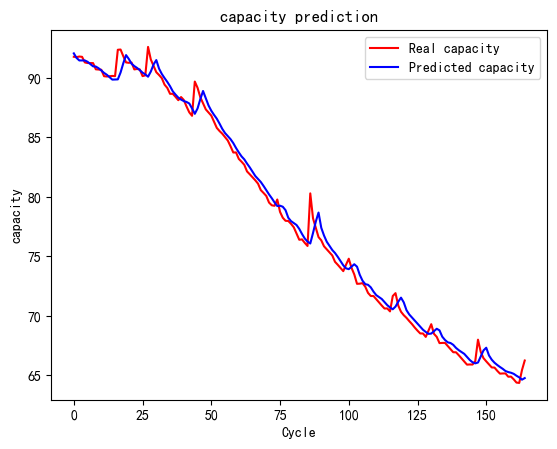

rmse: 0.7985754314608005
mape: 0.7772363446783597


In [129]:
#画图
plt.plot(y_5, color = 'red', label = 'Real capacity')
plt.plot(y_pred_5, color = 'blue', label = 'Predicted capacity')
plt.title('capacity prediction')
plt.xlabel('Cycle')
plt.ylabel('capacity')
plt.legend()
plt.show()

#评估模型
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse=np.sqrt(mean_squared_error(y_5,y_pred_5))
mape=np.mean(np.abs((y_5-y_pred_5)/y_5))*100

print('rmse:',rmse)
print('mape:',mape)


In [130]:
#上一步数据标准化
elm5=pred5.values.reshape(-1,1)
elm5=scaler.transform(elm5)
elm6=pred6.values.reshape(-1,1)
elm6=scaler.transform(elm6)
elm7=pred7.values.reshape(-1,1)
elm7=scaler.transform(elm7)
elm18=pred18.values.reshape(-1,1)
elm18=scaler.transform(elm18)

#构建时间序列
elm_sequ5_x,elm_sequ5_y = time_series(elm5, window_size)
elm_sequ6_x,elm_sequ6_y = time_series(elm6, window_size)
elm_sequ7_x,elm_sequ7_y = time_series(elm7, window_size)
elm_sequ18_x,elm_sequ18_y = time_series(elm18, window_size)


In [131]:
target_x=elm_sequ18_x
target_y=elm_sequ18_y
target_real=y_18

In [132]:
#单步预测
target_pred = model.predict(target_x)
target_pred = scaler.inverse_transform(target_pred)

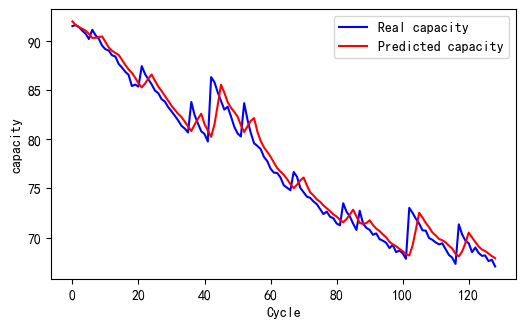

rmse: 1.3203529765241453
mape: 1.2748812080309788


In [133]:
#画图
plt.figure(figsize=(6,3.5))
plt.plot(target_real, color = 'blue', label = 'Real capacity')
plt.plot(target_pred, color = 'red', label = 'Predicted capacity')

plt.xlabel('Cycle')
plt.ylabel('capacity')
plt.legend()
plt.show()


#评估模型
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse=np.sqrt(mean_squared_error(target_real,target_pred))
mape=np.mean(np.abs((target_real-target_pred)/target_real))*100

print('rmse:',rmse)
print('mape:',mape)

In [134]:
#迭代预测
def recursive_predict(X,threshold):
    count=0
    y_list=[]
    y_pred = model.predict(X.reshape(-1,window_size,1))
    while(y_pred[0][0]>=threshold):
        y_list.append(y_pred)
        X=np.vstack((X[1:],y_pred.reshape(-1,1)))
        y_pred = model.predict(X.reshape(-1,window_size,1))
        count+=1
        if(count>400):
            break

    return y_list

threshold: 0.3927102723038691
第 0 个样本预测结果： 213
第 1 个样本预测结果： 210
第 2 个样本预测结果： 209
第 3 个样本预测结果： 208
第 4 个样本预测结果： 206
第 5 个样本预测结果： 203
第 6 个样本预测结果： 200
第 7 个样本预测结果： 203
第 8 个样本预测结果： 203
第 9 个样本预测结果： 201
第 10 个样本预测结果： 196
第 11 个样本预测结果： 192
第 12 个样本预测结果： 191
第 13 个样本预测结果： 189
第 14 个样本预测结果： 186
第 15 个样本预测结果： 182
第 16 个样本预测结果： 177
第 17 个样本预测结果： 174
第 18 个样本预测结果： 170
第 19 个样本预测结果： 164
第 20 个样本预测结果： 160
第 21 个样本预测结果： 157
第 22 个样本预测结果： 165
第 23 个样本预测结果： 169
第 24 个样本预测结果： 167
第 25 个样本预测结果： 161
第 26 个样本预测结果： 157
第 27 个样本预测结果： 152
第 28 个样本预测结果： 146
第 29 个样本预测结果： 141
第 30 个样本预测结果： 135
第 31 个样本预测结果： 131
第 32 个样本预测结果： 127
第 33 个样本预测结果： 123
第 34 个样本预测结果： 115
第 35 个样本预测结果： 110
第 36 个样本预测结果： 105
第 37 个样本预测结果： 122
第 38 个样本预测结果： 126
第 39 个样本预测结果： 123
第 40 个样本预测结果： 111
第 41 个样本预测结果： 103
第 42 个样本预测结果： 94
第 43 个样本预测结果： 130
第 44 个样本预测结果： 152
第 45 个样本预测结果： 157
第 46 个样本预测结果： 148
第 47 个样本预测结果： 138
第 48 个样本预测结果： 134
第 49 个样本预测结果： 129
第 50 个样本预测结果： 119
第 51 个样本预测结果： 110
第 52 个样本预测结果： 103
第 53 个样本预测结果： 120
第 54 个样本预

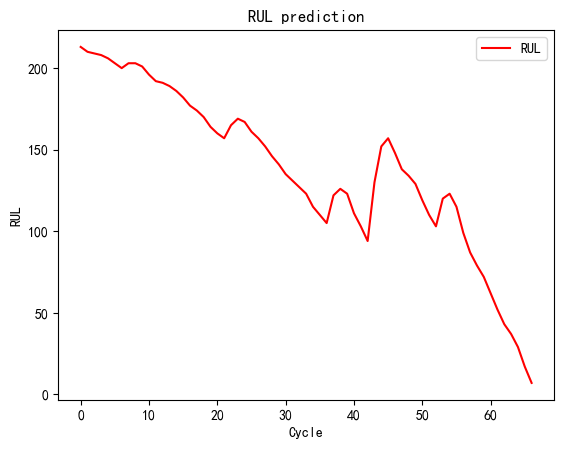

In [135]:
#迭代过程
threshold=75
threshold_norm=scaler.transform(np.array(threshold).reshape(-1,1))
threshold_norm=threshold_norm[0][0]
print('threshold:',threshold_norm)

rul_list=[]
for i in range(len(target_x)):
    if(target_x[i][-1]<threshold_norm):
        break
    pred_list=recursive_predict(target_x[i].reshape(-1,1),threshold_norm)
    rul_list.append(len(pred_list))
    print('第',i,'个样本预测结果：',len(pred_list))


#画图
plt.plot(rul_list, color = 'red', label = 'RUL')
plt.title('RUL prediction')
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.legend()
plt.show()


66


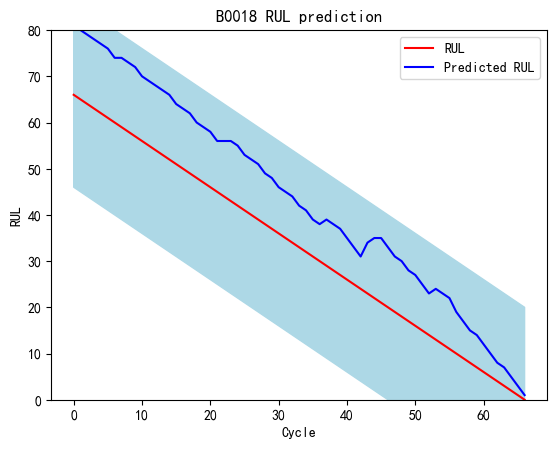

0.25011853959222385
0.6575943810359965


In [149]:
for i in range(len(target_real)):
    if(target_real[i]<threshold):
        break
threshold_point=i
print (i)
#生成RUL
rul=np.zeros(i+1)
for i in range(len(rul)):
    rul[i]=threshold_point-i

rul_pred=np.array(rul_list)+window_size
rul_pred=(rul_pred-rul[:])/10+rul[:]
#化为整数
rul_pred=np.round(rul_pred)

#画图
plt.plot(rul[:], color = 'red', label = 'RUL')
plt.plot(rul_pred, color = 'blue', label = 'Predicted RUL')

#在rul上下距离20的范围内画出淡蓝色区域
plt.fill_between(np.arange(len(rul[:])),rul[:]-20,rul[:]+20,color='lightblue')

plt.title('B0018 RUL prediction')
plt.xlabel('Cycle')
plt.ylabel('RUL')
#y轴下界
plt.ylim(0,80)
plt.legend()
plt.show()

#计算线性拟合的R2
from sklearn.metrics import r2_score
print(r2_score(rul[30:],rul_pred[30:]))
print(r2_score(rul[:],rul_pred[:]))


In [137]:
# #实验window_size对预测结果的影响
# window_size_list=[3,4,5,6,7]
# rmse_list1=[]
# rmse_list2=[]
# rmse_list3=[]
# rmse_list4=[]
# for window_size_test in window_size_list:
#     sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size_test)
#     sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size_test)
#     sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size_test)
#     sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size_test)
#     _,y_5=time_series(real_5,window_size_test)
#     _,y_6=time_series(real_6,window_size_test)
#     _,y_7=time_series(real_7,window_size_test)
#     _,y_18=time_series(real_18,window_size_test)
#     sequ_x=np.vstack((sequ_x_6,sequ_x_7,sequ_x_18))
#     sequ_y=np.vstack((sequ_y_6,sequ_y_7,sequ_y_18))
#     model=build_model(window_size=window_size_test,dropout=0.2,activation='tanh',lstm_size=80)
#     model.fit(sequ_x_5, sequ_y_5, epochs=100, batch_size=32)
#     y_pred_5 = model.predict(sequ_x_5)
#     y_pred_5 = scaler.inverse_transform(y_pred_5)

#     rmse=np.sqrt(np.mean(y_pred_5-y_5)**2)
#     rmse_list1.append(rmse)


# for window_size_test in window_size_list:
#     sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size_test)
#     sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size_test)
#     sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size_test)
#     sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size_test)
#     _,y_5=time_series(real_5,window_size_test)
#     _,y_6=time_series(real_6,window_size_test)
#     _,y_7=time_series(real_7,window_size_test)
#     _,y_18=time_series(real_18,window_size_test)
#     sequ_x=np.vstack((sequ_x_5,sequ_x_7,sequ_x_18))
#     sequ_y=np.vstack((sequ_y_5,sequ_y_7,sequ_y_18))
#     model=build_model(window_size=window_size_test,dropout=0.2,activation='tanh',lstm_size=80)
#     model.fit(sequ_x_6, sequ_y_6, epochs=100, batch_size=32)
#     y_pred = model.predict(sequ_x_6)
#     y_pred = scaler.inverse_transform(y_pred)

#     rmse=np.sqrt(np.mean(y_pred-y_6)**2)
#     rmse_list2.append(rmse)

# for window_size_test in window_size_list:
#     sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size_test)
#     sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size_test)
#     sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size_test)
#     sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size_test)
#     _,y_5=time_series(real_5,window_size_test)
#     _,y_6=time_series(real_6,window_size_test)
#     _,y_7=time_series(real_7,window_size_test)
#     _,y_18=time_series(real_18,window_size_test)
#     sequ_x=np.vstack((sequ_x_5,sequ_x_6,sequ_x_18))
#     sequ_y=np.vstack((sequ_y_5,sequ_y_6,sequ_y_18))
#     model=build_model(window_size=window_size_test,dropout=0.2,activation='tanh',lstm_size=80)
#     model.fit(sequ_x_7, sequ_y_7, epochs=100, batch_size=32)
#     y_pred = model.predict(sequ_x_7)
#     y_pred = scaler.inverse_transform(y_pred)

#     rmse=np.sqrt(np.mean(y_pred-y_7)**2)
#     rmse_list3.append(rmse)

# for window_size_test in window_size_list:
#     sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size_test)
#     sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size_test)
#     sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size_test)
#     sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size_test)
#     _,y_5=time_series(real_5,window_size_test)
#     _,y_6=time_series(real_6,window_size_test)
#     _,y_7=time_series(real_7,window_size_test)
#     _,y_18=time_series(real_18,window_size_test)
#     sequ_x=np.vstack((sequ_x_5,sequ_x_6,sequ_x_7))
#     sequ_y=np.vstack((sequ_y_5,sequ_y_6,sequ_y_7))
#     model=build_model(window_size=window_size_test,dropout=0.2,activation='tanh',lstm_size=80)
#     model.fit(sequ_x_18, sequ_y_18, epochs=100, batch_size=32)
#     y_pred = model.predict(sequ_x_18)
#     y_pred = scaler.inverse_transform(y_pred)

#     rmse=np.sqrt(np.mean(y_pred-y_18)**2)
#     rmse_list4.append(rmse)

# rmse_list=[]
# for i in range(len(window_size_list)):
#     rmse_list.append((rmse_list1[i]+rmse_list2[i]+rmse_list3[i]+rmse_list4[i])/4)




# plt.bar(window_size_list,rmse_list)
# plt.title('RMSE of different window_size')
# plt.xlabel('window_size')
# plt.ylabel('RMSE')
# plt.show()



In [138]:
# plt.figure(figsize=(8,5))
# plt.bar(window_size_list,rmse_list,width=0.6)
# plt.title('RMSE of different window_size')
# plt.xlabel('window_size')
# plt.ylabel('RMSE')
# plt.show()

In [139]:
# #实验window_size对预测结果的影响
# window_size_list=[3,4,5,6,7]
# rmse_list=[]
# for window_size_test in window_size_list:
#     sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size_test)
#     sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size_test)
#     sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size_test)
#     sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size_test)
#     _,y_5=time_series(real_5,window_size_test)
#     _,y_6=time_series(real_6,window_size_test)
#     _,y_7=time_series(real_7,window_size_test)
#     _,y_18=time_series(real_18,window_size_test)
#     sequ_x=np.vstack((sequ_x_5,sequ_x_7,sequ_x_18))
#     sequ_y=np.vstack((sequ_y_5,sequ_y_7,sequ_y_18))
#     model=build_model(window_size=window_size_test,dropout=0.2,activation='tanh',lstm_size=80)
#     model.fit(sequ_x_6, sequ_y_6, epochs=100, batch_size=32)
#     y_pred_5 = model.predict(sequ_x_5)
#     y_pred_5 = scaler.inverse_transform(y_pred_5)

#     rmse=np.sqrt(np.mean(y_pred_5-y_5)**2)
#     rmse_list.append(rmse)

# plt.bar(window_size_list,rmse_list)
# plt.title('RMSE of different window_size')
# plt.xlabel('window_size')
# plt.ylabel('RMSE')
# plt.show()



In [140]:
# #使用最优参数搭建模型
# window_size=4


# sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size)
# sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size)
# sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size)
# sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size)
# _,y_5=time_series(real_5,window_size)
# _,y_6=time_series(real_6,window_size)
# _,y_7=time_series(real_7,window_size)
# _,y_18=time_series(real_18,window_size)
# sequ_x=np.vstack((sequ_x_5,sequ_x_6,sequ_x_7,sequ_x_18))
# sequ_y=np.vstack((sequ_y_5,sequ_y_6,sequ_y_7,sequ_y_18))
# model=build_model(window_size=window_size,dropout=0.2,activation='tanh',lstm_size=80)
# model.fit(sequ_x_5, sequ_y_5, epochs=100, batch_size=32)
# y_pred_5 = model.predict(sequ_x_5)
# y_pred_5 = scaler.inverse_transform(y_pred_5)

# #画图
# plt.plot(y_5, color = 'red', label = 'Real capacity')
# plt.plot(y_pred_5, color = 'blue', label = 'Predicted capacity')
# plt.title('capacity prediction')
# plt.xlabel('Cycle')
# plt.ylabel('capacity')
# plt.legend()
# plt.show()

